# Proyek Akhir: Menyelesaikan Permasalahan Perusahaan Edutech

- Nama: Rehan Athallah Azhar
- Email: Azharrehan502@gmail.com
- Id Dicoding: rehan_azhar

**Latar Belakang**

  Jaya Jaya Institut merupakan salah satu institusi pendidikan perguruan yang telah berdiri sejak tahun 2000. Hingga saat ini ia telah mencetak banyak lulusan dengan reputasi yang sangat baik. Akan tetapi, terdapat banyak juga siswa yang tidak menyelesaikan pendidikannya alias dropout.

  Jumlah dropout yang tinggi ini tentunya menjadi salah satu masalah yang besar untuk sebuah institusi pendidikan. Oleh karena itu, Jaya Jaya Institut ingin mendeteksi secepat mungkin siswa yang mungkin akan melakukan dropout sehingga dapat diberi bimbingan khusus.


**Pertanyaan Bisnis**
1. Berapa proporsi mahasiswa yang keluar (drop out) dibandingkan total mahasiswa?
2. Bagaimana distribusi status mahasiswa berdasarkan berbagai fitur?
3. Faktor apa saja yang paling mempengaruhi kelulusan/dropout mahasiswa?

**Tujuan**
1. Mengidentifikasi besaran proporsi mahasiswa yg drop out
2. Distribusi status mahasiswa berdasarkan berbagai fitur
3. Faktor yang paling mempengaruhi kelulusan/dropout mahasiswa




## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
import numpy as np
import re

import os
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pyspark.sql.window import Window
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, regexp_extract, udf, isnull, count, trim, isnan
from pyspark.sql.types import StructType, StructField, ByteType, ShortType, IntegerType, FloatType, StringType, DoubleType
from pyspark.ml.feature import PCA
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import VectorAssembler, PCA, StandardScaler

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql.types import ArrayType

def vec_to_array(v):
    return v.toArray().tolist()

vector_to_array_udf = udf(vec_to_array, ArrayType(DoubleType()))

In [3]:
# Membuat sesi Spark
spark = SparkSession.builder.appName("student-performance").getOrCreate()

### Menyiapkan data yang akan digunakan

In [4]:
schema = StructType([
    StructField("Marital_status", ByteType(), True),
    StructField("Application_mode", ShortType(), True),
    StructField("Application_order", ShortType(), True),
    StructField("Course", IntegerType(), True),
    StructField("Daytime_evening_attendance", ByteType(), True),
    StructField("Previous_qualification", ShortType(), True),
    StructField("Previous_qualification_grade", FloatType(), True),
    StructField("Nacionality", ShortType(), True),
    StructField("Mothers_qualification", ShortType(), True),
    StructField("Fathers_qualification", ShortType(), True),
    StructField("Mothers_occupation", ShortType(), True),
    StructField("Fathers_occupation", ShortType(), True),
    StructField("Admission_grade", FloatType(), True),
    StructField("Displaced", ByteType(), True),
    StructField("Educational_special_needs", ByteType(), True),
    StructField("Debtor", ByteType(), True),
    StructField("Tuition_fees_up_to_date", ByteType(), True),
    StructField("Gender", ByteType(), True),
    StructField("Scholarship_holder", ByteType(), True),
    StructField("Age_at_enrollment", ShortType(), True),
    StructField("International", ByteType(), True),
    StructField("Curricular_units_1st_sem_credited", ByteType(), True),
    StructField("Curricular_units_1st_sem_enrolled", ByteType(), True),
    StructField("Curricular_units_1st_sem_evaluations", ByteType(), True),
    StructField("Curricular_units_1st_sem_approved", ByteType(), True),
    StructField("Curricular_units_1st_sem_grade", FloatType(), True),
    StructField("Curricular_units_1st_sem_without_evaluations", FloatType(), True),
    StructField("Curricular_units_2nd_sem_credited", ByteType(), True),
    StructField("Curricular_units_2nd_sem_enrolled", ByteType(), True),
    StructField("Curricular_units_2nd_sem_evaluations", ByteType(), True),
    StructField("Curricular_units_2nd_sem_approved", ByteType(), True),
    StructField("Curricular_units_2nd_sem_grade", FloatType(), True),
    StructField("Curricular_units_2nd_sem_without_evaluations", ByteType(), True),
    StructField("Unemployment_rate", FloatType(), True),
    StructField("Inflation_rate", FloatType(), True),
    StructField("GDP", FloatType(), True),
    StructField("Status", StringType(), True)
])


df = spark.read.format("csv") \
    .option("header", "true") \
    .option("sep", ";") \
    .schema(schema) \
    .load("./data.csv")


df.printSchema()

root
 |-- Marital_status: byte (nullable = true)
 |-- Application_mode: short (nullable = true)
 |-- Application_order: short (nullable = true)
 |-- Course: integer (nullable = true)
 |-- Daytime_evening_attendance: byte (nullable = true)
 |-- Previous_qualification: short (nullable = true)
 |-- Previous_qualification_grade: float (nullable = true)
 |-- Nacionality: short (nullable = true)
 |-- Mothers_qualification: short (nullable = true)
 |-- Fathers_qualification: short (nullable = true)
 |-- Mothers_occupation: short (nullable = true)
 |-- Fathers_occupation: short (nullable = true)
 |-- Admission_grade: float (nullable = true)
 |-- Displaced: byte (nullable = true)
 |-- Educational_special_needs: byte (nullable = true)
 |-- Debtor: byte (nullable = true)
 |-- Tuition_fees_up_to_date: byte (nullable = true)
 |-- Gender: byte (nullable = true)
 |-- Scholarship_holder: byte (nullable = true)
 |-- Age_at_enrollment: short (nullable = true)
 |-- International: byte (nullable = true)
 

In [5]:
df.show(5)

+--------------+----------------+-----------------+------+--------------------------+----------------------+----------------------------+-----------+---------------------+---------------------+------------------+------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+-----------------+--------------+-----+--------+
|Marital_status|Application_mode|Application_order|Course|Daytime_evening_attendance|Previous_qualification|Previous_qualification_grade|Nacionality|

## Data Understanding

In [6]:
# check null value
df.select([
    count(when(col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()

+--------------+----------------+-----------------+------+--------------------------+----------------------+----------------------------+-----------+---------------------+---------------------+------------------+------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+-----------------+--------------+---+------+
|Marital_status|Application_mode|Application_order|Course|Daytime_evening_attendance|Previous_qualification|Previous_qualification_grade|Nacionality|Moth

In [7]:
count_duplicate = df.count() - df.dropDuplicates().count()
count_duplicate

0

In [8]:
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+--------------------------+----------------------+----------------------------+------------------+---------------------+---------------------+------------------+------------------+------------------+-------------------+-------------------------+-------------------+-----------------------+-------------------+-------------------+------------------+--------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+------------------+------------------+--------------------+--------+
|summary|    Marital_status|  Application_mode| 

In [9]:
# Step 1: assume value 0 at grade coloumn is missing (null)
cols_with_zero_invalid = [
    "Previous_qualification_grade",
    "Admission_grade",
    "Curricular_units_1st_sem_grade",
    "Curricular_units_2nd_sem_grade"
]

for col_name in cols_with_zero_invalid:
    df = df.withColumn(col_name, when(col(col_name) == 0, None).otherwise(col(col_name)))

In [10]:
# Step 2: fix negative value at Unemployment_rate dan Inflation_rate coloumn
df = df.withColumn(
    "Unemployment_rate",
    when(col("Unemployment_rate") < 0, None).otherwise(col("Unemployment_rate"))
)

df = df.withColumn(
    "Inflation_rate",
    when(col("Inflation_rate") < 0, None).otherwise(col("Inflation_rate"))
)

In [11]:
# Step 3: Normalization Status coloumn (remove spaces)
df = df.withColumn("Status", trim(col("Status")))

In [12]:
# count missing value
missing_df = df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns
])

missing_df.show()

# count missing value in percent
total_rows = df.count()

missing_percentage = missing_df.select([
    (col(c) / total_rows * 100).alias(c) for c in missing_df.columns
])

missing_percentage.show()

+--------------+----------------+-----------------+------+--------------------------+----------------------+----------------------------+-----------+---------------------+---------------------+------------------+------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+-----------------+--------------+---+------+
|Marital_status|Application_mode|Application_order|Course|Daytime_evening_attendance|Previous_qualification|Previous_qualification_grade|Nacionality|Moth

In [13]:
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+--------------------------+----------------------+----------------------------+------------------+---------------------+---------------------+------------------+------------------+------------------+-------------------+-------------------------+-------------------+-----------------------+-------------------+-------------------+------------------+--------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+------------------+------------------+--------------------+--------+
|summary|    Marital_status|  Application_mode| 

In [14]:
# Columns that want to implement ffill dan bfill
missing_columns = [
    'Curricular_units_1st_sem_grade',
    'Curricular_units_2nd_sem_grade'
]

# Remove missing value on Inflation_rate coloumn
df = df.dropna(subset=['Inflation_rate'])

# 1. Set up window based on Course
window_ffill = Window.partitionBy('Course').orderBy('Age_at_enrollment').rowsBetween(Window.unboundedPreceding, 0)
window_bfill = Window.partitionBy('Course').orderBy('Age_at_enrollment').rowsBetween(0, Window.unboundedFollowing)

# 2. Implement ffill dan bfill
for col in missing_columns:
    # Forward fill
    df = df.withColumn(
        col,
        F.last(col, ignorenulls=True).over(window_ffill)
    )
    # Backward fill
    df = df.withColumn(
        col,
        F.when(
            F.col(col).isNull(),
            F.first(col, ignorenulls=True).over(window_bfill)
        ).otherwise(F.col(col))
    )

df.show()


+--------------+----------------+-----------------+------+--------------------------+----------------------+----------------------------+-----------+---------------------+---------------------+------------------+------------------+---------------+---------+-------------------------+------+-----------------------+------+------------------+-----------------+-------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+---------------------------------+---------------------------------+------------------------------------+---------------------------------+------------------------------+--------------------------------------------+-----------------+--------------+-----+--------+
|Marital_status|Application_mode|Application_order|Course|Daytime_evening_attendance|Previous_qualification|Previous_qualification_grade|Nacionality|

In [15]:
from pyspark.sql.functions import col

numerical_cols = [
    'Application_order', 'Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment',
    'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled',
    'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved',
    'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations',
    'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled',
    'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved',
    'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations',
    'Unemployment_rate', 'Inflation_rate', 'GDP'
]

def cap_outliers_iqr(df, column):
    q1 = df.approxQuantile(column, [0.25], 0.0)[0]
    q3 = df.approxQuantile(column, [0.75], 0.0)[0]
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df = df.withColumn(column, when(col(column) < lower, lower)
                                   .when(col(column) > upper, upper)
                                   .otherwise(col(column)))
    return df

for col_name in numerical_cols:
    df = cap_outliers_iqr(df, col_name)


**Explanation**


1. **Why is Inflation_rate removed?**

  Inflation_rate is not student-specific data; it is a macroeconomic condition of the country.

  We don’t know if the Inflation_rate applies to:
  - The year the student enrolled,
  - The year of graduation,
  - Or the current year.

  Since there is no clear relationship between Inflation_rate and student-related variables, it’s better to remove it to avoid contaminating the model or analysis.

  Rather than risking incorrect imputation or interpretation, it’s safer to discard it.

2. **Why continue with ffill & bfill for Curricular_units_1st_sem_grade and Curricular_units_2nd_sem_grade?**

  Both columns represent students' academic grades → It makes sense to perform imputation within a single course.

  We assume that students within the same course and cohort have similar grading patterns.

  Forward fill (ffill) and backward fill (bfill) are still applied, grouped by Course, to maintain academic validity.

### EDA

In [16]:
cleaned_df = df  # without copy, its already save in PySpark
data_pandas = cleaned_df.toPandas()

In [17]:
# export
data_pandas.to_csv(
    "./output.csv",
    index=False,
    mode='w',
    header=True
)

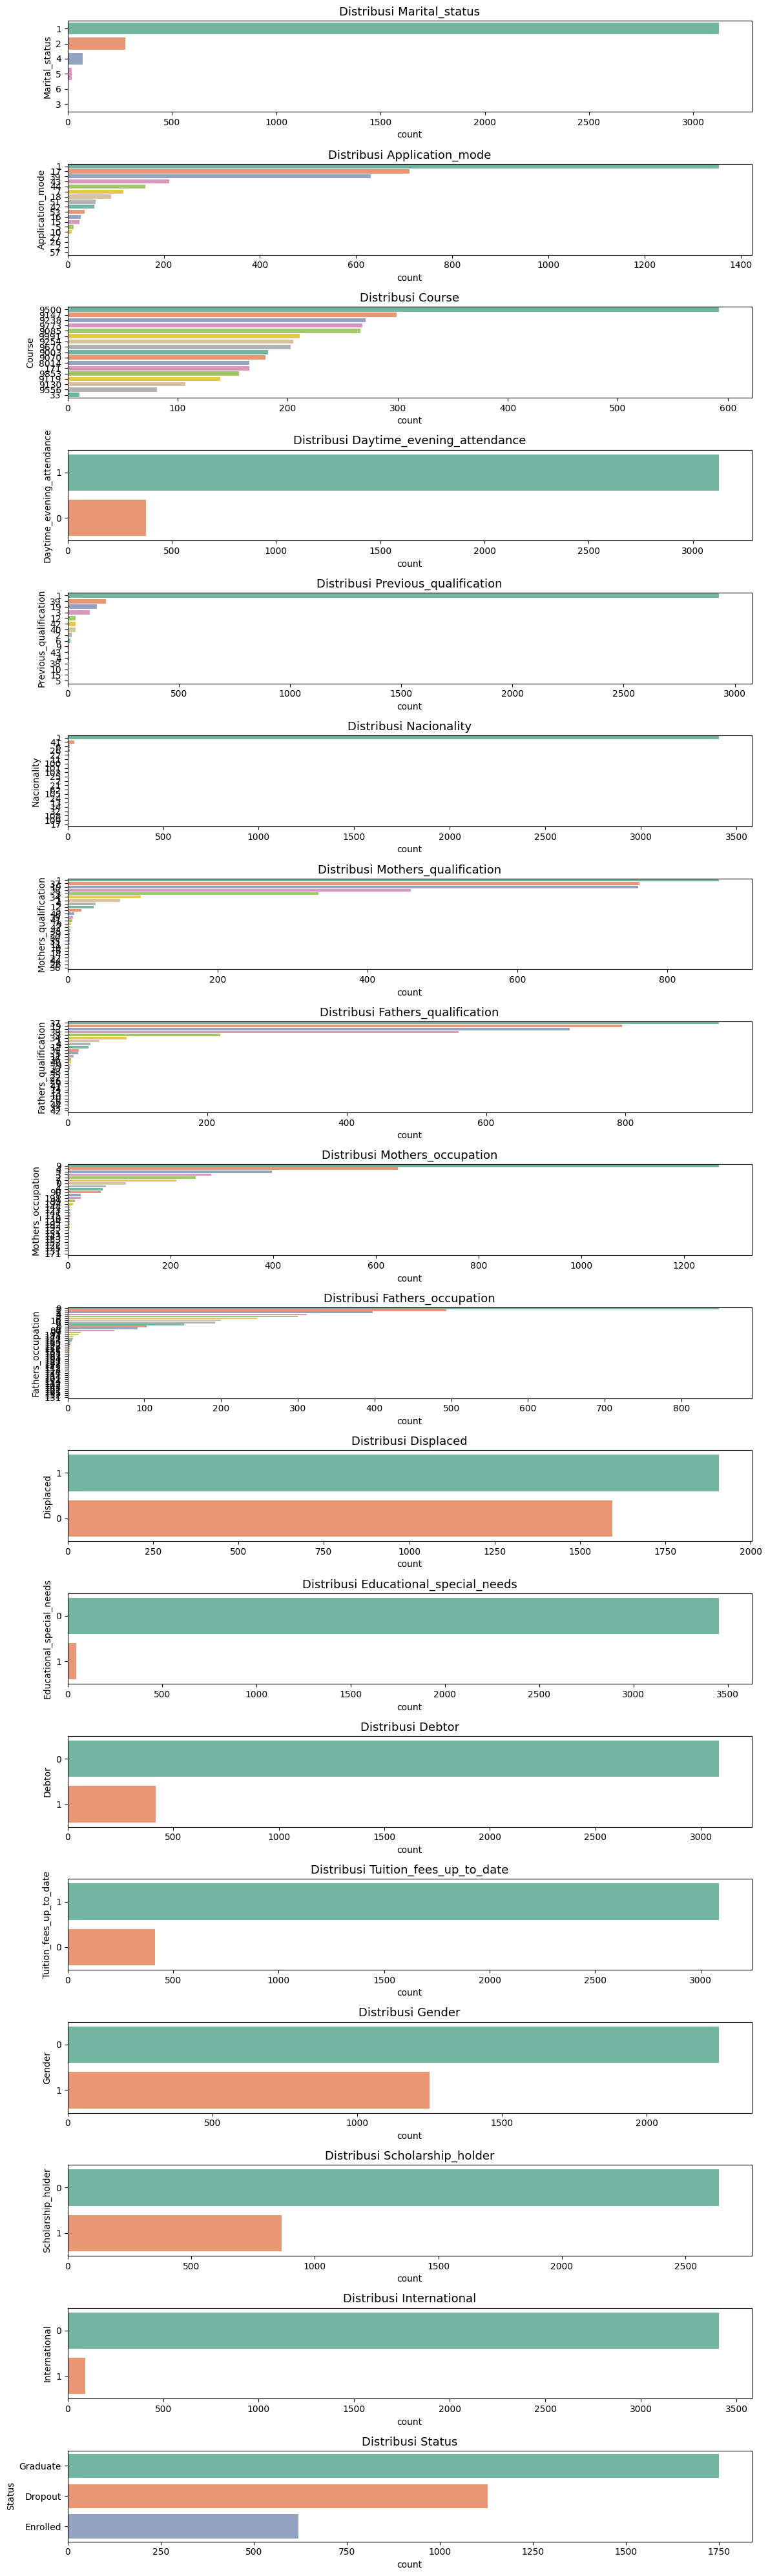

In [18]:
# Categorical coloumn list
categorical_cols = ['Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance',
                    'Previous_qualification', 'Nacionality', 'Mothers_qualification',
                    'Fathers_qualification', 'Mothers_occupation',
                    'Fathers_occupation', 'Displaced', 'Educational_special_needs', 'Debtor',
                    'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'International', 'Status']

fig, ax = plt.subplots(len(categorical_cols), 1, figsize=(12, 40))

for i, col_name in enumerate(categorical_cols):
    sns.countplot(y=col_name, data=data_pandas,
                  order=data_pandas[col_name].value_counts().index,
                  ax=ax[i], palette="Set2")
    ax[i].set_title(f'Distribusi {col_name}', fontsize=13)
    ax[i].tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

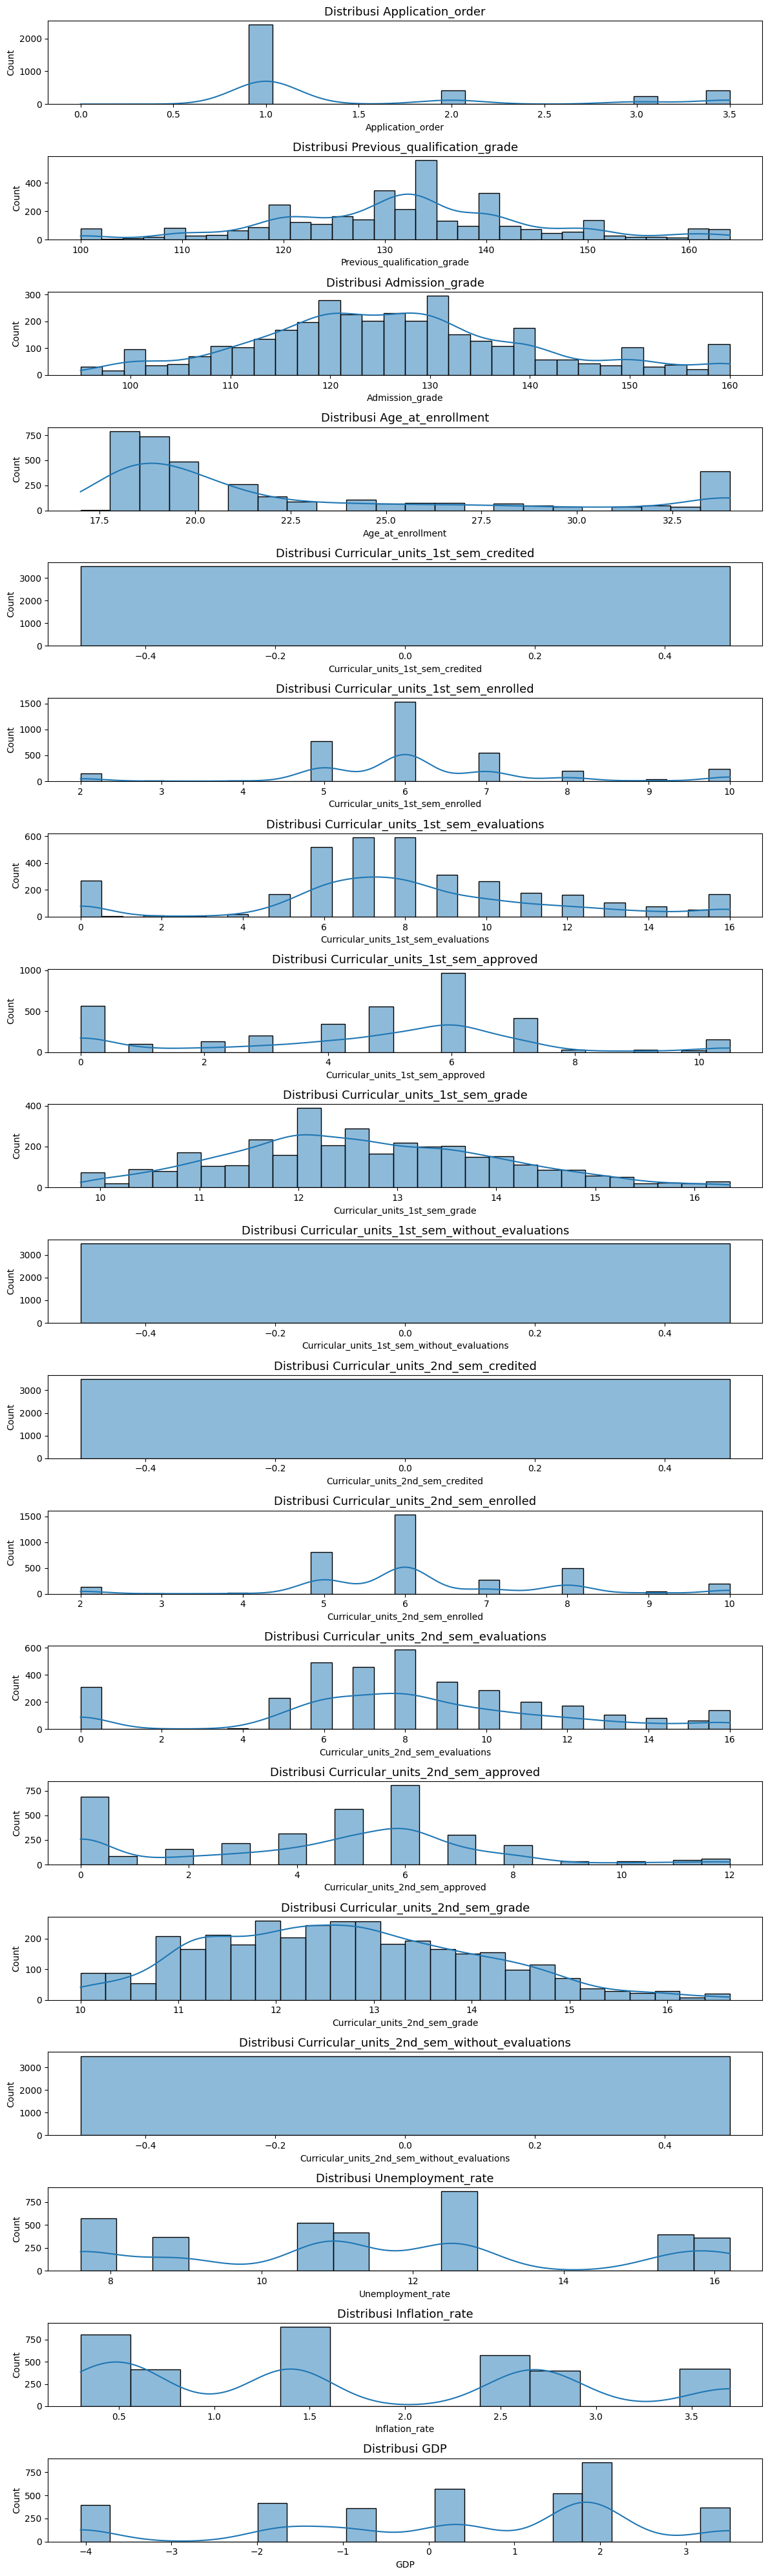

In [19]:
# Numerical coloumn list
numerical_cols = [
    'Application_order', 'Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment',
    'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled',
    'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved',
    'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations',
    'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled',
    'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved',
    'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations',
    'Unemployment_rate', 'Inflation_rate', 'GDP'
]

fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(12, 40))

for i, col_name in enumerate(numerical_cols):
    sns.histplot(data=data_pandas, x=col_name, kde=True, ax=ax[i])
    ax[i].set_title(f'Distribusi {col_name}', fontsize=13)
    ax[i].tick_params(axis='x', labelsize=10)

plt.tight_layout()
plt.show()

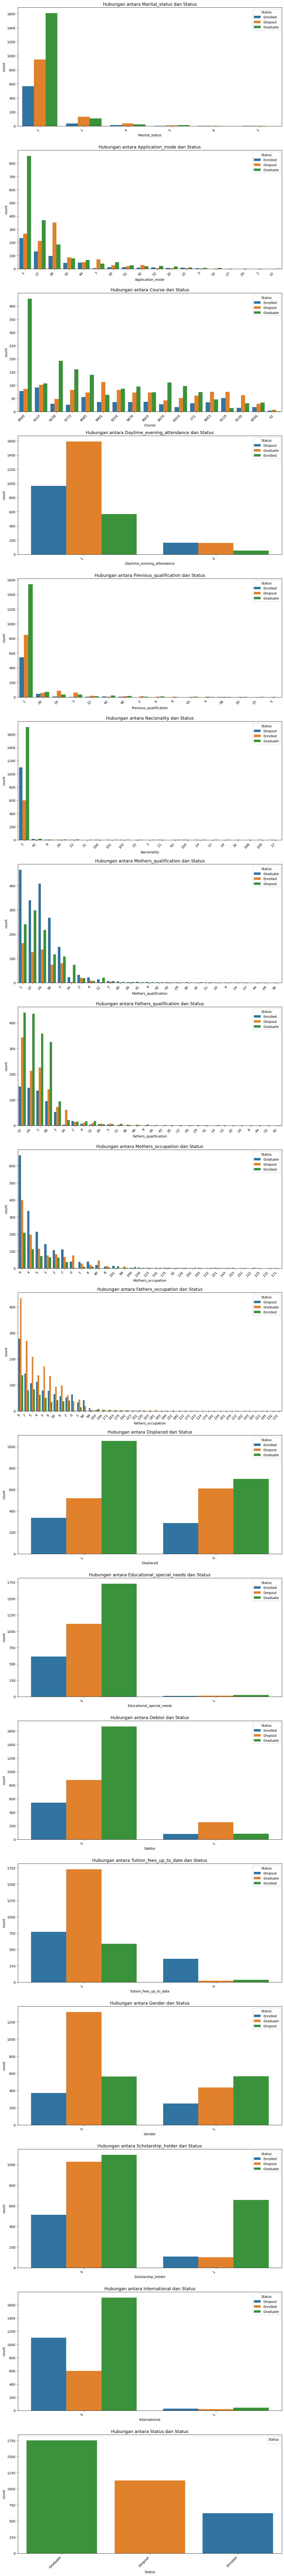

In [20]:
# Visualization of the relationship between categorical features and the 'Status' column
# categorical coloumn list (without 'Status', because it will be the target/hue)
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(12, 6 * len(categorical_cols)))

for i, col_name in enumerate(categorical_cols):
    sns.countplot(data=data_pandas, x=col_name, hue='Status',
                  order=data_pandas[col_name].value_counts().index,
                  ax=axes[i])
    axes[i].set_title(f'Hubungan antara {col_name} dan Status', fontsize=13)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), ha='right')  # In order not to overlap
    axes[i].legend(title='Status', loc='upper right')

plt.tight_layout()
plt.show()


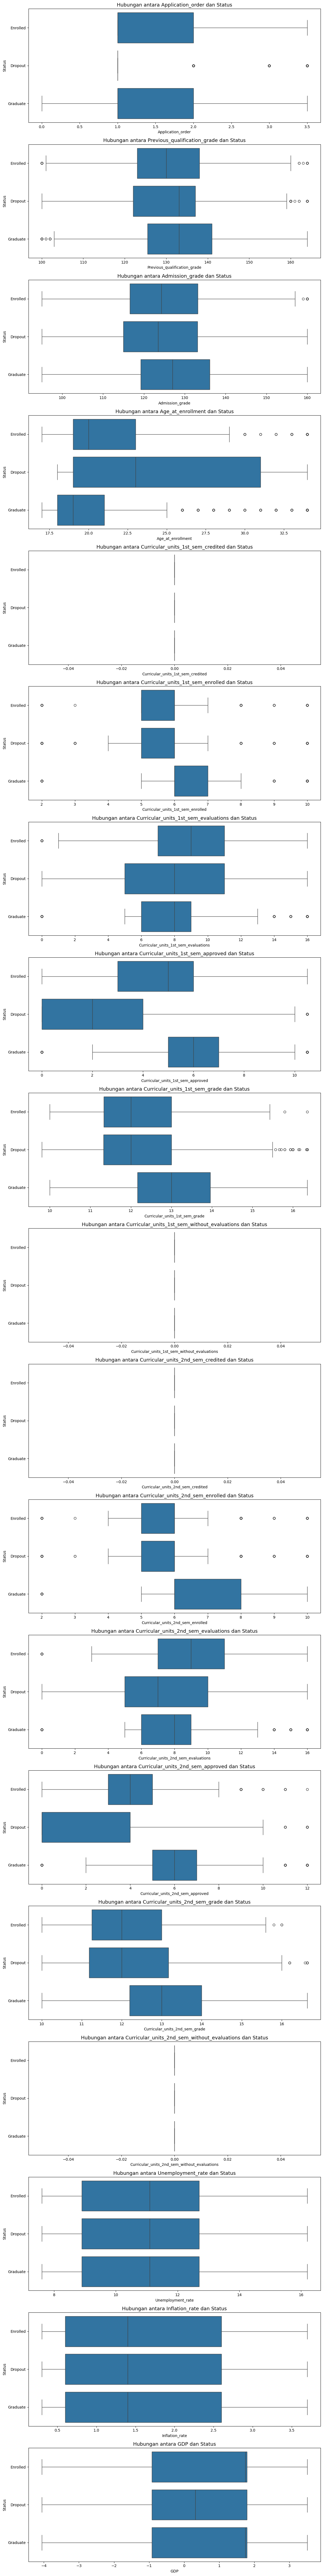

In [21]:
# Boxplot visualization of numerical feature relationship with target 'Status'

fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(12, 5 * len(numerical_cols)))

for i, col_name in enumerate(numerical_cols):
    sns.boxplot(data=data_pandas, x=col_name, y='Status', ax=axes[i])
    axes[i].set_title(f'Hubungan antara {col_name} dan Status', fontsize=13)
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel('Status')

plt.tight_layout()
plt.show()

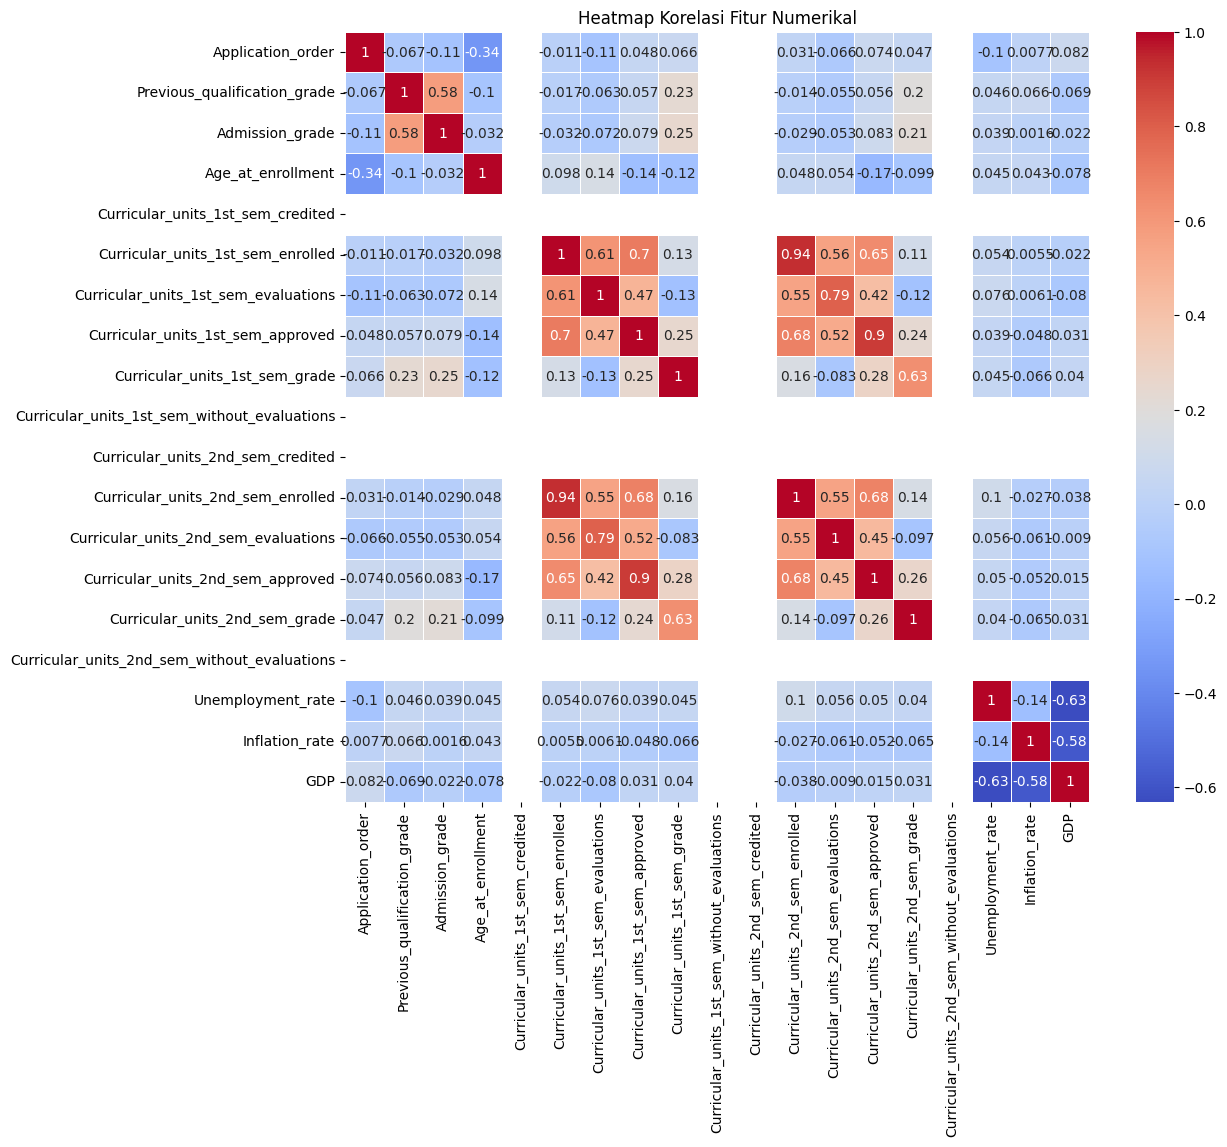

In [22]:
# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select(numerical_cols).toPandas().corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Heatmap Korelasi Fitur Numerikal')
plt.show()

In [23]:
# URL = os.environ.get("DATABASE_URL")
# engine = create_engine(URL)

# data_pandas.columns = [col.lower() for col in data_pandas.columns]

# # export data to supabase
# data_pandas.to_sql('student', con=engine, if_exists='replace', index=False)

**Explanation**

**Gambar 1 – Histogram Distribusi untuk Setiap Kolom Kategorikal**
- Marital Status: Sebagian besar mahasiswa berstatus single, sangat sedikit yang married, divorced, atau lainnya. Ini normal mengingat mayoritas mahasiswa biasanya masih muda.

- Application Mode: Ada satu atau dua mode aplikasi yang dominan (kemungkinan besar 1st phase - general contingent), sedangkan mode lainnya jarang dipilih. Ini menunjukkan jalur masuk utama lebih banyak digunakan dibanding jalur-jalur alternatif.

- Course: Distribusi menunjukkan bahwa ada jurusan tertentu yang sangat populer dibanding jurusan lain. Misalnya Management atau Nursing mungkin memiliki lebih banyak mahasiswa.

- Previous Qualification, Mother's and Father's Qualification, Occupation, dan Nationality: Banyak mahasiswa berasal dari latar belakang pendidikan menengah (Secondary education). Sebagian besar orang tua mereka memiliki tingkat pendidikan menengah ke bawah, sedikit sekali dari tingkat master atau doktor.

- Daytime/Evening Attendance: Mayoritas mahasiswa menghadiri kelas di daytime.

- Gender: Rasio female dan male bisa jadi tidak seimbang, misalnya, Nursing biasanya lebih banyak female.

- Displaced, Scholarship Holder, Educational Special Needs: Mayoritas mahasiswa bukan displaced students, tidak memiliki kebutuhan khusus, namun cukup banyak yang menerima beasiswa.

**Insight:** Mayoritas mahasiswa masih muda, belum menikah, berasal dari jalur aplikasi umum, latar pendidikan menengah, dan mengambil kuliah di siang hari.

<br>

**Gambar 2 – Histogram Distribusi untuk Kolom Numerik**
- Age at Enrollment: Distribusi usia condensed di rentang 17–22 tahun, tipikal untuk mahasiswa S1. Ada sedikit ekor ke kanan (outlier >25 tahun).

- Previous Qualification Grade dan Admission Grade: Nilai masuk umumnya tinggi (>130 dari 200), tapi ada sebaran yang cukup besar. Ada mahasiswa yang masuk dengan nilai rendah, mungkin dari jalur alternatif.

- Curricular Units 1st Sem (credited/enrolled/evaluations/approved):

- Sebagian besar mahasiswa mengambil dan menyelesaikan 6-8 mata kuliah.

- Jumlah approved sedikit lebih rendah dari enrolled, wajar karena ada mahasiswa yang tidak lulus semua mata kuliah.

**Insight:** Mahasiswa tipikal berusia 17–22 tahun dengan performa akademik awal cukup baik, namun ada variasi pada jumlah mata kuliah yang diselesaikan.

<br>

**Gambar 3 – Hubungan antara Status (Dropout/Enrolled/Graduate) dan Setiap Kolom Kategorikal**
- **Target vs Final Situation** :
    - Mayoritas mahasiswa berakhir dengan status 'Drop-out'
    - Mahasiswa yang 'Graduate' lebih banyak dibandingkan dengan 'Enrolled'
- **Distribusi Berdasarkan Atribut Kategori** :
    - Banyak atribut kategori (seperti 'Mother's qualification', 'Father's qualification', dll.) menunjukkan bahwa sebagian besar mahasiswa berasal dari latar belakang pendidikan rendah hingga sedang
    - Beberapa fitur seperti Scholarship menunjukkan distribusi yang berat ke arah tidak menerima beasiswa
    - Debtor status dan Tuition fees up to date menunjukkan bahwa mahasiswa yang tidak punya utang dan membayar tepat waktu memiliki angka kelulusan yang lebih tinggi
- **Final Situation vs Academic Performance** :
    - Mahasiswa yang lulus (graduate) cenderung memiliki jumlah mata kuliah lulus dan evaluasi yang lebih tinggi di semester 1 dan 2
    - Ada hubungan kuat antara keberhasilan akademik awal dan hasil akhir studi

<br>

**Gambar 4 – Hubungan antara Status dan Setiap Kolom Numerik**
- **Admission Grade vs Final Situation** :
    - Mahasiswa yang lulus memiliki nilai masuk yang lebih tinggi dibandingkan dropout dan yang masih aktif (enrolled)
    - Ada penyimpangan (outlier) pada semua kategori, tapi median pada lulusan tetap lebih tinggi
- **Curricular Units Semester 1 dan 2** :
    - Mahasiswa yang drop-out memiliki nilai evaluasi dan jumlah mata kuliah yang disetujui lebih rendah di semester awal
    - Jumlah evaluasi tanpa nilai tinggi pada mahasiswa drop-out, mengindikasikan ketidakhadiran atau ketidakseriusan
    - Jumlah mata kuliah yang diambil tetapi tidak diselesaikan juga tinggi pada mahasiswa yang gagal

**Gambar 5 – Heatmap Korelasi**

- Korelasi tinggi :
    - Curricular_units_1st_sem_enrolled dan Curricular_units_1st_sem_credited
    - Curricular_units_1st_sem_credited dan Curricular_units_1st_sem_approved
    - Fitur-fitur semester 2 juga memiliki pola serupa
- Admission grade berkorelasi positif dengan nilai semester 1 dan 2, meskipun tidak sangat kuat (maks sekitar 0.59).
- GDP, Unemployment rate, dan Inflation rate tidak menunjukkan korelasi signifikan terhadap variabel akademik



**Kesimpulan Akhir**
1. Keberhasilan akademik awal (semester 1 dan 2) sangat berkaitan dengan kelulusan mahasiswa.

2. Faktor sosio-ekonomi seperti pendidikan orang tua, status utang, dan pembayaran biaya kuliah juga mempengaruhi hasil akhir studi.

3. Mahasiswa dengan nilai masuk tinggi dan performansi akademik baik sejak awal cenderung menyelesaikan studinya.

4. Fitur-fitur eksternal seperti GDP dan tingkat pengangguran tidak terlalu memengaruhi performa mahasiswa.


## Data Preparation / Preprocessing

In [24]:
train_df, test_df = cleaned_df.randomSplit([0.7, 0.3], seed=42)
print(f"Train count: {train_df.count()}")
print(f"Test count: {test_df.count()}")

Train count: 2506
Test count: 995


In [25]:
# Undersampling
from pyspark.sql.functions import col

status_counts = train_df.groupBy("Status").count().collect()
min_count = min([row["count"] for row in status_counts])

undersampled_dfs = []
for row in status_counts:
    status_value = row["Status"]
    df_class = train_df.filter(col("Status") == status_value)
    sampled_df = df_class.sample(withReplacement=False, fraction=min_count / row["count"], seed=42)
    undersampled_dfs.append(sampled_df)

undersampled_train_df = undersampled_dfs[0]
for df in undersampled_dfs[1:]:
    undersampled_train_df = undersampled_train_df.union(df)

print(f"Undersampled Train count: {undersampled_train_df.count()}")
undersampled_train_df.groupBy("Status").count().show()

Undersampled Train count: 1370
+--------+-----+
|  Status|count|
+--------+-----+
|Enrolled|  439|
| Dropout|  460|
|Graduate|  471|
+--------+-----+



In [26]:
# Feature Engineering
# categorical_columns = ['marital_status', 'application_mode',
#     'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification',
#     'previous_qualification_grade', 'nacionality', 'mothers_qualification', 'fathers_qualification',
#     'mothers_occupation', 'fathers_occupation', 'admission_grade', 'displaced', 'educational_special_needs',
#     'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'age_at_enrollment', 'international',
#     'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations',
#     'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations',
#     'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations',
#     'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations',
#     'unemployment_rate', 'inflation_rate', 'gdp', 'status']

lower_categorical_cols = [col.lower() for col in categorical_cols]

indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid='keep') for col in lower_categorical_cols if col != 'status']
label_indexer = StringIndexer(inputCol="status", outputCol="label", handleInvalid='keep')
feature_cols = [col + "_index" for col in lower_categorical_cols if col != 'status']
assembler = VectorAssembler(inputCols=feature_cols, outputCol="assembled_features")
scaler = MinMaxScaler(inputCol="assembled_features", outputCol="scaled_features")

pipeline = Pipeline(stages=indexers + [label_indexer, assembler, scaler])

In [27]:
# Lowercase column names
undersampled_train_df = undersampled_train_df.select([col(c).alias(c.lower()) for c in undersampled_train_df.columns])
test_df = test_df.select([col(c).alias(c.lower()) for c in test_df.columns])

pipeline_model = pipeline.fit(undersampled_train_df)
final_train_df = pipeline_model.transform(undersampled_train_df)
final_test_df = pipeline_model.transform(test_df)

final_train_df.select("scaled_features", "label").show(5, truncate=False)

+----------------------------------------------------------------------------------------+-----+
|scaled_features                                                                         |label|
+----------------------------------------------------------------------------------------+-----+
|(17,[2,7,8,9,10,14],[0.75,0.19047619047619047,0.12,0.24242424242424243,1.0,1.0])        |2.0  |
|(17,[2,6,7,14],[0.75,0.05,0.09523809523809523,1.0])                                     |2.0  |
|(17,[2,6,7,8,9,12,14],[0.75,0.05,0.047619047619047616,0.08,0.09090909090909091,1.0,1.0])|2.0  |
|(17,[2,7,8,9,12,14],[0.75,0.09523809523809523,0.2,0.09090909090909091,1.0,1.0])         |2.0  |
|(17,[2,6,7,8,9],[0.75,0.05,0.14285714285714285,0.04,0.06060606060606061])               |2.0  |
+----------------------------------------------------------------------------------------+-----+
only showing top 5 rows



In [28]:
# Apply PCA 1
pca1 = PCA(k=5, inputCol="scaled_features", outputCol="pca_features_1")
pca_model_1 = pca1.fit(final_train_df)
final_train_df = pca_model_1.transform(final_train_df)

In [29]:
# Apply PCA 2 (optional or if needed on other features)
pca2 = PCA(k=2, inputCol="scaled_features", outputCol="pca_features_2")
pca_model_2 = pca2.fit(final_train_df)
final_train_df = pca_model_2.transform(final_train_df)

In [30]:
# Extract PCA features
final_train_df = final_train_df.withColumn("pca_array_1", vector_to_array_udf("pca_features_1"))
final_train_df = final_train_df.withColumn("pca_array_2", vector_to_array_udf("pca_features_2"))

for i in range(5):
    final_train_df = final_train_df.withColumn(f"pc1_{i+1}", col("pca_array_1")[i].cast(DoubleType()))
for i in range(2):
    final_train_df = final_train_df.withColumn(f"pc2_{i+1}", col("pca_array_2")[i].cast(DoubleType()))

In [31]:
# Assemble final features for modeling
pca_cols = [f"pc1_{i+1}" for i in range(5)] + [f"pc2_{i+1}" for i in range(2)]
assembler = VectorAssembler(inputCols=pca_cols, outputCol="features")
final_train_df = assembler.transform(final_train_df)

## Modeling

In [32]:
# Hyperopt Optimization
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [33]:
# Decision Tree Hyperopt
def objective_dt(params):
    model = DecisionTreeClassifier(labelCol='label', featuresCol='features', maxDepth=int(params['maxDepth']))
    pipeline = Pipeline(stages=[model])
    fitted_model = pipeline.fit(final_train_df)
    predictions = fitted_model.transform(final_train_df)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    return {'loss': -accuracy, 'status': STATUS_OK}

best_params_dt = fmin(fn=objective_dt, space={'maxDepth': hp.quniform('dt_maxDepth', 2, 10, 1)}, algo=tpe.suggest, max_evals=20, trials=Trials())

100%|██████████| 20/20 [03:46<00:00, 11.32s/trial, best loss: -0.7102189781021898]


In [34]:
# Random Forest Hyperopt
def objective_rf(params):
    model = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=int(params['numTrees']), maxDepth=int(params['maxDepth']), maxBins=32)
    pipeline = Pipeline(stages=[model])
    fitted_model = pipeline.fit(final_train_df)
    predictions = fitted_model.transform(final_train_df)
    evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    return {'loss': -accuracy, 'status': STATUS_OK}

best_params_rf = fmin(fn=objective_rf, space={'numTrees': hp.quniform('rf_numTrees', 50, 150, 10), 'maxDepth': hp.quniform('rf_maxDepth', 3, 10, 1)}, algo=tpe.suggest, max_evals=20, trials=Trials())

100%|██████████| 20/20 [04:37<00:00, 13.88s/trial, best loss: -0.7598540145985402]


In [35]:
# Train Decision Tree with best hyperparameters
final_dt_model = DecisionTreeClassifier(
    labelCol='label',
    featuresCol='features',
    maxDepth=int(best_params_dt['dt_maxDepth'])
)

pipeline_dt = Pipeline(stages=[final_dt_model]).fit(final_train_df)

In [36]:
# TrainRandom Forest with best hyperparameters
final_rf_model = RandomForestClassifier(
    labelCol='label',
    featuresCol='features',
    numTrees=int(best_params_rf['rf_numTrees']),
    maxDepth=int(best_params_rf['rf_maxDepth']),
    maxBins=32
)

pipeline_rf = Pipeline(stages=[final_rf_model]).fit(final_train_df)

In [37]:
input_fields = [
    'marital_status', 'application_mode', 'application_order', 'course',
    'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade',
    'nacionality', 'mothers_qualification', 'fathers_qualification',
    'mothers_occupation', 'fathers_occupation', 'admission_grade', 'displaced',
    'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender',
    'scholarship_holder', 'age_at_enrollment', 'international',
    'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations',
    'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations',
    'unemployment_rate', 'inflation_rate', 'gdp'
]

# Tambah assembler dan scaler
assembler_raw = VectorAssembler(inputCols=input_fields, outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="scaled_features")

In [38]:
# Delete the column that will be overwritten before the pipeline
cols_to_drop = ['pca_features_1', 'pca_features_2', 'scaled_features']  # dan lainnya jika ada
final_train_df = final_train_df.drop(*[c for c in cols_to_drop if c in final_train_df.columns])

In [39]:
!rm -rf model/rf_best_model

In [40]:
# saving model
pipeline_stages = [
    assembler_raw,
    scaler,
    pca1,
    RandomForestClassifier(
        labelCol='label',
        featuresCol='pca_features_1',
        numTrees=int(best_params_rf['rf_numTrees']),
        maxDepth=int(best_params_rf['rf_maxDepth']),
        maxBins=32
    )
]



pipeline = Pipeline(stages=pipeline_stages)
pipeline_model = pipeline.fit(final_train_df)
pipeline_model.write().overwrite().save("model/rf_best_model")

In [41]:
!zip -r rf_best_model.zip model/rf_best_model

  adding: model/rf_best_model/ (stored 0%)
  adding: model/rf_best_model/stages/ (stored 0%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/ (stored 0%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/data/ (stored 0%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/data/.part-00000-cd339c43-b095-4585-a050-80f22cfa5710-c000.snappy.parquet.crc (stored 0%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/data/._SUCCESS.crc (stored 0%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/data/_SUCCESS (stored 0%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/data/part-00000-cd339c43-b095-4585-a050-80f22cfa5710-c000.snappy.parquet (deflated 56%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/metadata/ (stored 0%)
  adding: model/rf_best_model/stages/1_StandardScaler_a9f8ac9d4b72/metadata/part-00000 (deflated 38%)
  adding: model/rf_best_model/stages/1_StandardS

## Evaluation

In [42]:
def evaluating(y_pred, y_true, labels, model_name):
    print(f"\n===== {model_name} Evaluation =====")
    print(classification_report(y_true=y_true, y_pred=y_pred, target_names=labels))
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=range(len(labels)))
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


===== Decision Tree Evaluation =====
              precision    recall  f1-score   support

     Dropout       0.72      0.77      0.74       471
    Enrolled       0.75      0.68      0.72       460
    Graduate       0.66      0.67      0.67       439

    accuracy                           0.71      1370
   macro avg       0.71      0.71      0.71      1370
weighted avg       0.71      0.71      0.71      1370



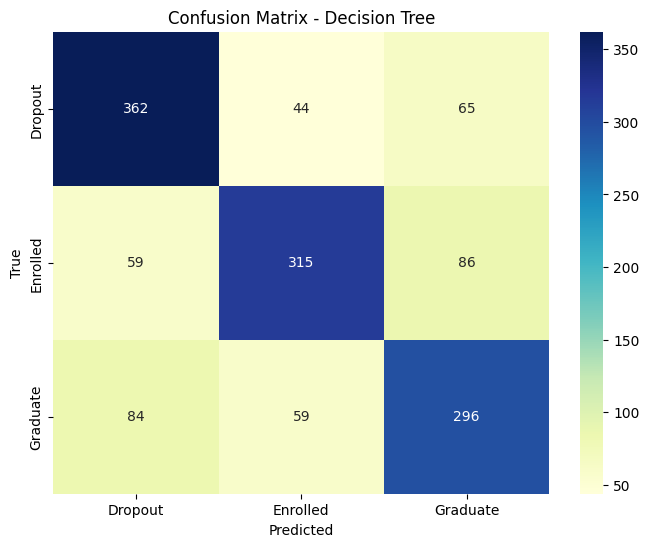

In [43]:
# Predict and evaluate Decision Tree
pred_dt = pipeline_dt.transform(final_train_df).select("label", "prediction").toPandas()
evaluating(pred_dt["prediction"], pred_dt["label"], labels=["Dropout", "Enrolled", "Graduate"], model_name="Decision Tree")


===== Random Forest Evaluation =====
              precision    recall  f1-score   support

     Dropout       0.74      0.82      0.77       471
    Enrolled       0.81      0.75      0.78       460
    Graduate       0.74      0.71      0.72       439

    accuracy                           0.76      1370
   macro avg       0.76      0.76      0.76      1370
weighted avg       0.76      0.76      0.76      1370



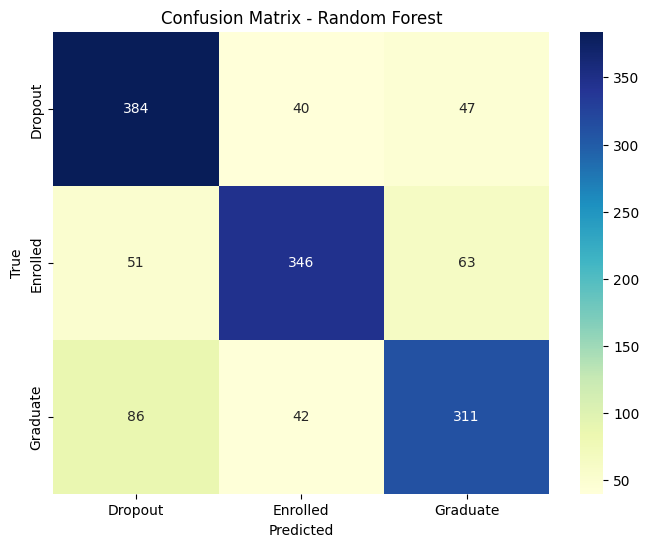

In [44]:
# Predict and evaluate Random Forest
pred_rf = pipeline_rf.transform(final_train_df).select("label", "prediction").toPandas()
evaluating(pred_rf["prediction"], pred_rf["label"], labels=["Dropout", "Enrolled", "Graduate"], model_name="Random Forest")

In [45]:
pandas_df = final_train_df.select(
    [f"pc1_{i+1}" for i in range(5)] + [f"pc2_{i+1}" for i in range(2)] + ["label"]
).toPandas()
X_pandas = pandas_df.drop(columns=["label"])
y_pandas = pandas_df["label"]

train_pca_df, test_pca_df, y_train, y_test = train_test_split(
    X_pandas, y_pandas, test_size=0.2, random_state=42, stratify=y_pandas
)


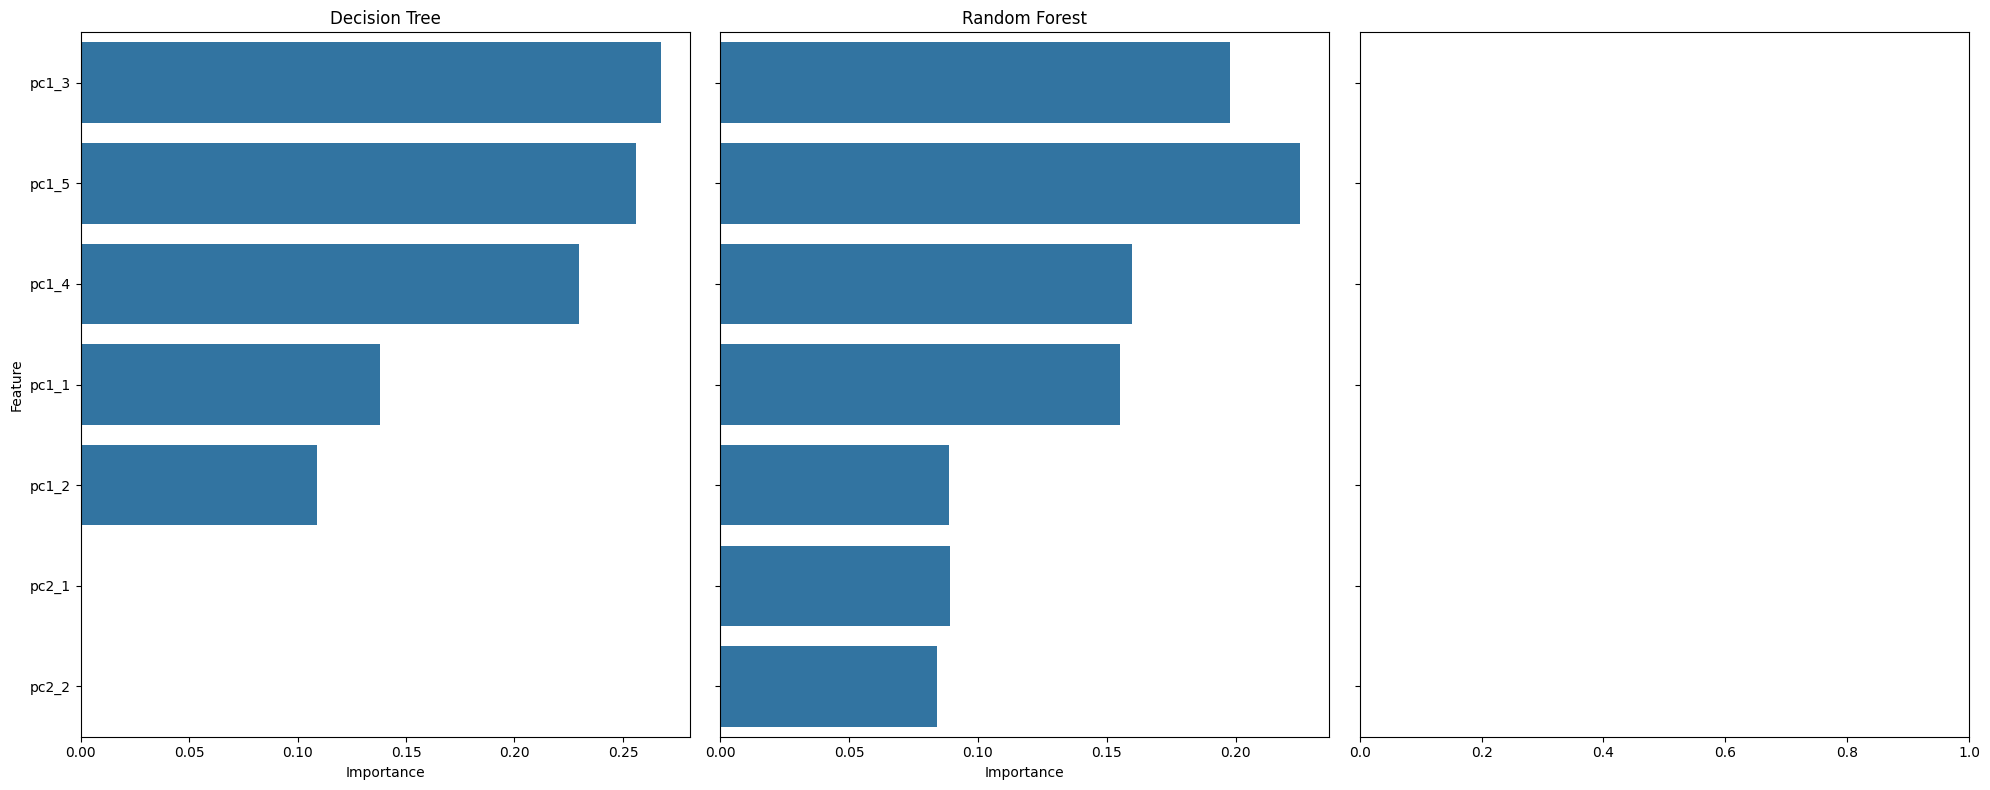

In [46]:
# Persiapan Data Feature Importance
importances_dt = pipeline_dt.stages[-1].featureImportances
feature_importance_dt = [(feature, importances_dt[idx]) for idx, feature in enumerate(train_pca_df.columns)]
feature_importance_dt = sorted(feature_importance_dt, key=lambda x: x[1], reverse=True)

importances_rf = pipeline_rf.stages[-1].featureImportances
feature_importance_rf = [(feature, importances_rf[idx]) for idx, feature in enumerate(train_pca_df.columns)]
feature_importance_rf = sorted(feature_importance_rf, key=lambda x: x[1], reverse=True)

# Plot dalam satu kanvas
fig, axs = plt.subplots(1, 3, figsize=(20, 8), sharey=True)

# Decision Tree
sns.barplot(ax=axs[0], x=[f[1] for f in feature_importance_dt], y=[f[0] for f in feature_importance_dt])
axs[0].set_title("Decision Tree")
axs[0].set_xlabel("Importance")
axs[0].set_ylabel("Feature")

# Random Forest
sns.barplot(ax=axs[1], x=[f[1] for f in feature_importance_rf], y=[f[0] for f in feature_importance_rf])
axs[1].set_title("Random Forest")
axs[1].set_xlabel("Importance")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()


In [47]:
feature_cols = [
    "Marital_status_idx", "Application_mode_idx", "Course_idx", "Daytime_evening_attendance_idx",
    "Previous_qualification_idx", "Nacionality_idx", "Mothers_qualification_idx", "Fathers_qualification_idx",
    "Mothers_occupation_idx", "Fathers_occupation_idx", "Displaced_idx", "Educational_special_needs_idx", "Debtor_idx",
    "Tuition_fees_up_to_date_idx", "Gender_idx", "Scholarship_holder_idx", "International_idx"
]

pc_matrix = pca_model_1.pc.toArray()

# Create a DataFrame of the feature's contribution to the main component
pc_df = pd.DataFrame(pc_matrix, columns=[f'PC{i+1}' for i in range(pc_matrix.shape[1])], index=feature_cols)

# Calculate the absolute contribution to PC1
pc_df['PC1_abs'] = pc_df['PC1'].abs()

# sort descending
pc_df_sorted = pc_df.sort_values(by='PC1_abs', ascending=False)

print(pc_df_sorted[['PC1']])



                                     PC1
Displaced_idx                  -0.668246
Gender_idx                     -0.632876
Scholarship_holder_idx          0.253043
Tuition_fees_up_to_date_idx    -0.162733
Debtor_idx                     -0.144193
Course_idx                     -0.131274
Daytime_evening_attendance_idx -0.131115
Application_mode_idx           -0.057711
Fathers_occupation_idx         -0.033233
Previous_qualification_idx     -0.031970
Marital_status_idx             -0.030435
Fathers_qualification_idx      -0.018130
Mothers_occupation_idx         -0.014182
International_idx              -0.011578
Mothers_qualification_idx      -0.008735
Educational_special_needs_idx   0.007868
Nacionality_idx                -0.000671


In [48]:
# Calculate the total absolute contribution of all principal components (PC1 to PC5)
pc_df['total_abs'] = pc_df[[f'PC{i+1}' for i in range(5)]].abs().sum(axis=1)

# sort descending
pc_df_sorted = pc_df.sort_values(by='total_abs', ascending=False)

feature_importance = pc_df_sorted[['total_abs']]
print(feature_importance)

                                total_abs
Scholarship_holder_idx           2.018677
Gender_idx                       1.800893
Displaced_idx                    1.654417
Debtor_idx                       1.265929
Daytime_evening_attendance_idx   1.167531
Tuition_fees_up_to_date_idx      1.136160
Course_idx                       0.992837
Application_mode_idx             0.179151
Marital_status_idx               0.161437
Previous_qualification_idx       0.117111
Fathers_occupation_idx           0.114267
Mothers_qualification_idx        0.099779
Mothers_occupation_idx           0.083423
Fathers_qualification_idx        0.078641
International_idx                0.069221
Educational_special_needs_idx    0.032024
Nacionality_idx                  0.029779


In [49]:
spark.stop()

## Pertanyaan Bisnis & Jawaban
1. Berapa proporsi mahasiswa yang keluar (drop out) dibandingkan total mahasiswa?
  - International Student :
    - 32,27% Dropout
    - 17,57% Enrolled
    - 50,16% Graduate
  - Domestic student :
    - 31,52% Dropout
    - 23,91% Enrolled
    - 44,57% Graduate

2. Bagaimana distribusi status mahasiswa berdasarkan berbagai fitur

  Dari berbagai grafik bar dan boxplot:
  - **Beasiswa :** Mahasiswa yg menerima beasiswa cenderung memiliki tingkat dropout lebih tinggi daripada yg tidak meneirma beasiswa
  - **Jenis Kelamin:** Mahasiswa laki-laki cenderung memiliki tingkat dropout lebih tinggi dibanding perempuan.
  
  - **Umur saat masuk kuliah:** Umur lebih muda cenderung memiliki tingkat kelulusan yang lebih tinggi.
  
  - **Status Pernikahan:** Mahasiswa lajang mendominasi seluruh kategori, tetapi pernikahan tampaknya tidak signifikan memengaruhi status
  
  - **Pekerjaan & Pendidikan orang tua:** Mahasiswa dengan orang tua berpendidikan lebih tinggi atau bekerja dalam posisi profesional cenderung memiliki tingkat kelulusan lebih baik.
  
  - **Kredit & evaluasi semester:** Mahasiswa yang mengambil dan menyelesaikan lebih banyak mata kuliah semester 1 dan 2 memiliki kemungkinan lulus yang jauh lebih tinggi.
  
  - **Grade penerimaan (Admission Grade):** Semakin tinggi admission grade, semakin besar peluang untuk lulus.
  
  - **Faktor ekonomi (GDP, Pengangguran, Inflasi):** Korelasi kecil tapi terlihat bahwa lingkungan ekonomi yang lebih baik mendukung tingkat kelulusan lebih tinggi.

  3. Faktor yang paling mempengaruhi kelulusan/dropout mahasiswa?
  
    Berdasarkan PCA
    - Scholarship_holder        
    - Gender                      
    - Displaced                  
    - Daytime_evening_attendance   
    - Tuition_fees_up_to_date    
    - Debtor                    
    - Course             

# Kesimpulan
1. Secara keseluruhan, tingkat dropout mahasiswa, baik internasional maupun domestik, cukup tinggi, dan status kelulusan sangat dipengaruhi oleh berbagai faktor.
2. Faktor-faktor yg menjadi pemicu mahasiswa dropout dapat dilihat melalui hasil analisis PCA yang meliputi
  - Perbandingan mahasiswa yg tidak menerima beasiswa cenderung memiliki tingkat dropout lebih tinggi daripada yg tidak meneirma beasiswa
  - Mahasiswa laki-laki cenderung memiliki tingkat dropout lebih tinggi dibanding perempuan.
  - Mahasiswa yg terlantar cenderung memiliki tingkat dropout lebih tinggi
  - Mahasiswa yang sering tidak hadir cenderung akan dropout
  - Masalah biaya pendidikan menunggak juga menjadi salah satu faktor penting
  - Mahasiswa dengan orang tua berpendidikan lebih tinggi atau bekerja dalam posisi profesional cenderung memiliki tingkat kelulusan lebih baik.
  - Mahasiswa yang mengambil dan menyelesaikan lebih banyak mata kuliah semester 1 dan 2 memiliki kemungkinan lulus yang jauh lebih tinggi.

3. Pipeline data preprocessing dan model prediktif menggunakan Random Forest telah di-otomatisasi menggunakan Spark ML. Model ini memungkinkan integrasi ke dalam sistem operasional institusi untuk memantau status setiap siswa secara langsung dan mengeluarkan peringatan dini bila probabilitas dropout melewati ambang batas.

# Action Items
1. **Perkuat dukungan akademik di semester awal**
Banyak mahasiswa gagal di semester awal. Fokuskan bimbingan dan monitoring intensif pada semester 1 dan 2.

2. **Bantu mahasiswa dengan kesulitan keuangan**
Fitur Debtor dan Tuition_fees_up_to_date sangat memengaruhi kelulusan. Tawarkan program bantuan keuangan atau beasiswa.

3. **Pantau dan evaluasi mahasiswa dengan latar belakang kurang mampu**
Mahasiswa dengan orang tua dengan pendidikan rendah atau pendapatan rendah memerlukan perhatian tambahan.

4. **Fasilitasi pembelajaran yang mendukung penyelesaian mata kuliah**
Mahasiswa yang menyelesaikan lebih banyak mata kuliah punya peluang lulus lebih besar. Dorong partisipasi dan hindari "tidak hadir ujian".